# 1. Focal Loss Function

Trong bài báo được trình bày vào tháng 1, 2018 tựa đề [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf), nhóm tác giả `Tsung-Yi Lin, Priya Goyal, ...` của FAIR (Facebook AI research) đã công bố một hàm loss function mới mang tính đột phá trong việc cải thiện hiệu xuất của lớp mô hình one-stage detector trong object detection.

Dựa trên nhận định rằng mất cân bằng dữ liệu giữa các nhóm foreground-background là nguyên nhân chính dẫn tới sự kém hiệu quả, xin trích dẫn :

`We discover that the extreme foreground-background class imbalance encountered
during training of dense detectors is the central cause`

Nhóm tác giả đã đề xuất một sự điều chỉnh trong hàm cross entropy loss để giải quyết triệt để ảnh hưởng của mất cân bằng dữ liệu. Cụ thể về phương pháp mà các tác gỉa đã áp dụng như thế nào? Hãy cùng tôi khám phá qua bài viết này.

# 2. Cross Entropy Loss

Chúng ta đã được làm quen với hàm [cross entropy](https://phamdinhkhanh.github.io/2020/07/25/GAN_Wasserstein.html#2-cross-entropy). Xin nhắc lại
giá trị cross entropy đối với phân phối xác suất thực tế $\mathbf{p}$ và phân phối xác suất dự báo $\mathbf{q}$: 

$$CE(\mathbf{p}, \mathbf{q}) \triangleq \mathbf{H}(\mathbf{p}, \mathbf{q}) = -\sum_{i=1}^{C}p_i\log({q_i})$$


Tại các nhãn bằng 0 giá trị đóng góp vào loss function bằng 0. Do đó cross entropy có thể viết lại thành :

$$CE(\mathbf{p}, \mathbf{q}) = -\log(q_i), \text{with} ~ p_i=1$$

Trong cross entropy ta thấy rằng vai trò đóng góp vào loss function của các class cùng bằng -$\log(p_i)$. Khi xảy ra hiện tượng mất cân bằng, chúng ta muốn rằng mô hình sẽ dự báo chuẩn hơn đối với những class thiểu số. Do đó cần một hàm loss function hiệu quả hơn, có thể điều chỉnh được giá trị phạt lớn hơn đối với nhóm thiểu số. Mục đích là để hạn chế dự báo sai nhóm thiểu số vì nếu dự báo sai nhóm thiểu số thì hàm loss function sẽ trở nên lớn hớn.

# 3. Hàm balanced cross entropy

Các tự nhiên nhất là áp dụng trọng số bằng nghịch đảo tần suất nhãn vào cross entropy. Hàm loss function mới được gọi là _balanced cross entropy_:

$$BCE(\mathbf{p}, \mathbf{q}) = -\alpha_i\log(q_i),~~~ \text{with} ~ p_i=1$$

Trong đó $\alpha_i = \frac{1}{f_i+\epsilon}$, $f_i$ là tần suất của class $i$. Chúng ta cộng thêm $\epsilon$ _dương rất nhỏ_ để tránh mẫu bằng 0. Với hàm loss function này, các classes xuất hiện ít hơn thì có giá trị tác động tới loss function lớn hơn.

Hàm _balanced cross entropy_ là hàm số cân bằng được tỷ lệ phân phối của mẫu. Nhưng nó chưa thực sự thay đổi được gradient descent của loss function. Trong khi mô hình được huấn luyện trên mẫu mất cân bằng trầm trọng có giá trị gradient descent chịu ảnh hưởng phần lớn bởi class chiếm đa số. Do đó chúng ta cần một sự điều chỉnh triệt để hơn giúp gia tăng ảnh hưởng của nhóm thiểu số lên gradient descent. Đó chính là hàm _focal loss_, một hàm số tiếp tục kế thừa _balanced cross entropy_ và điều chỉnh được _gradient descent_.

# 4. Sự ra đời của focal loss

Focal loss là hàm loss function lần đầu được giới thiệu trong RetinaNet. Hàm loss function này đã chứng minh được tính hiệu quả trong các bài toán object detection. Đây là lớp bài toán có sự mất cân bằng nghiêm trọng giữa hai class positive (các bounding box có chứa object) và negative (các bounding box chứa object). Thường thì _negative_ có số lượng lớn hơn _positive_ rất nhiều. Lấy ví dụ như hình bên dưới :


![](https://imgur.com/Rd5eSh2.png)

Chỉ có 4 bounding box thuộc positive (đường viền in đậm), các trường hợp còn lại thuộc nhóm negative.

Do đó nếu áp dụng loss function là hàm cross entropy sẽ giảm độ chính xác khi dự báo các bounding box có chứa object. Trong bài báo [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf) tác giả đã giới thiệu hàm Focal Loss dựa trên hai tham số là $\alpha, \gamma$ như sau:


$$FP(\mathbf{p}, \mathbf{q}) = -\alpha_i (1-q_i)^{\gamma} \log(q_i), ~~~ \text{with} ~ p_i=1$$

Chúng ta thường chọn giá trị $\gamma \in [0, 5]$.

Ta thấy hàm _focal loss_ chỉ thêm nhân tử $(1-q_i)^{\gamma}$ so với công thức của _balanced cross entropy_. Tuy nhiên nhân tử này lại có tác dụng rất lớn trong việc điều chỉnh _ảnh hưởng của nhãn_ lên đồng thời _loss function_ và _gradient descent_. Thật vậy, xét hai trường hợp dễ dự báo và khó dự báo :

* Dễ dự báo: Chúng ta thấy rằng mô hình huấn luyện trên mẫu mất cân bằng thường dự báo chính xác các mẫu đa số. Những trường hợp này được gọi là dễ dự báo. Xác suất $q_i$ của của các trường hợp dễ dự báo có xu hướng cao hơn. Do đó $(1-p_t)^{\gamma}$ có xu hướng rất nhỏ và dường như không tác động lên loss function đáng kể.

* Khó dự báo: Trường hợp khó dự báo thì $q_i$ là một giá trị nhỏ hơn. Do đó độ lớn tác động của nó lên loss function là $(1-q_i)^{\gamma}$ sẽ gần bằng 1. Mức độ tác động này lớn hơn rất nhiều lần so với trường hợp dễ dự báo. Cụ thể hơn, nếu trường hợp dễ dự báo có $p_i = 0.9$ và khó dự báo có $p_i = 0.1$ thì tỷ lệ chênh lệch của đóng góp vào loss function khi $\gamma=2$ sẽ là:

$$\frac{(1-0.1)^2}{(1-0.9)^2} = \frac{0.9^2}{0.1^2} = 81$$

Tỷ lệ này sẽ còn lớn hơn nữa nếu tăng $\gamma$ hoặc giá trị của $p_i$ đối với trường hợp dễ dự báo càng gần 1 và khó dự báo càng gần 0.

## 4.1. Tác động tới đạo hàm

Phần phân tích sắp tới đây sẽ khá nặng về toán, bạn đọc không quan tâm nhiều tới toán có thể bỏ qua và chỉ xem 2 note kết luận ở cuối chương.

Ta có đạo hàm của _focal loss_ như sau:

$$\begin {eqnarray}\frac{\delta FP(\mathbf{p}, \mathbf{q})}{\delta q_i} & = &\frac{-\alpha_i \delta [ (1-q_i)^{\gamma} \log(q_i)]}{\delta q_i} \\
& = & \frac{-\alpha_i[-\gamma(1-q_i)^{\gamma-1}\log(q_i)+\frac{(1-q_i)^\gamma}{q_i}]}{\delta q_i} \\
& = & \frac{\alpha_i(1-q_i)^\gamma [\frac{\gamma\log(q_i)}{1-q_i}-\frac{1}{q_i}]}{\delta q_i} \\
& \triangleq & \frac{\alpha_i(1-q_i)^\gamma g(x)}{\delta q_i}
\end{eqnarray}$$

Dòng thứ 4 ở biến đổi trên ta đã đặt $g(x) = [\frac{\gamma\log(q_i)}{1-q_i}-\frac{1}{q_i}]$.

Mặt khác ta có một bất đẳng thức hết sức quan trọng đối với $\log (x)$ khi $x \in (0, 1]$. Chắc hẳn bạn còn nhớ: 

$$\log (x) \geq \beta(\frac{1}{x}-1)$$ 
với $\forall \beta \leq -1$. 

Note: Hàm $\log$ tôi ký hiệu ở trên là logarith cơ số tự nhiên $e$ chứ không phải cơ số 10.

Chứng minh bất đẳng thức này bằng khảo sát sự biến thiên của đạo hàm khá đơn giản như sau:

Đặt $f(x) = \log(x)-\beta(\frac{1}{x}-1)$ suy ra:

$$f'(x) = \frac{1}{x}+\frac{\beta}{x^2}=\frac{x+\beta}{x^2} \leq \frac{1+\beta}{x^2} \leq 0$$

Như vậy $f(x)$ nghịch biến trên $(0, 1]$. Từ đó suy ra cực tiểu $\min_{x \in (0, 1]} f(x) = f(1) = 0$.

Tương tự ta cũng chứng minh được bất đẳng thức sau:

$$\log (x) \leq \beta(\frac{1}{x}-1)$$ 
với $\forall \beta \geq 0$.


Chúng ta có thể chứng minh bất đẳng thức này bằng đạo hàm khá dễ dàng. Phần chứng minh xin dành cho bạn đọc như một bài tập. Đẳng thức xảy ra tại $x = 1$.

Như vậy nếu chọn $\beta_1 \leq -1$  và $\beta_2 \geq 0$ là hai giá trị bất kỳ ta có:

$$g(x) = \frac{\gamma\log(q_i)}{1-q_i}-\frac{1}{q_i} \geq \frac{\gamma\beta_1(\frac{1}{q_i}-1)}{1-q_i}-\frac{1}{q_i} = \gamma\beta_1-1 = C_1$$

Và đồng thời :

$$g(x) = \frac{\gamma\log(q_i)}{1-q_i}-\frac{1}{q_i} \leq \frac{\gamma\beta_2(\frac{1}{q_i}-1)}{1-q_i}-\frac{1}{q_i} = \gamma\beta_2-1 = C_2$$

Điều này chứng tỏ giá trị của $g(x)$ bị chặn trong đoạn $[C_1, C_2]$. Đây làm một nhận định hết sức quan trọng vì điều đó chứng tỏ rằng độ lớn gradient của _focal loss_ sẽ phần lớn phụ thuộc vào $(1-q_i)^{\gamma}$.

Bên dưới ta sẽ xét 2 trường hợp :

* Dễ dự báo: Giá trị $(1-p_t)^{\gamma}$ có xu hướng rất nhỏ và do đó ảnh hưởng của gradient descent của các trường hợp dễ dự báo không đáng kể.

* Khó dự báo: $(1-q_i)^{\gamma}$ sẽ gần bằng 1. Mức độ tác động lên gradient descent lớn hơn rất nhiều lần so với trường hợp dễ dự báo.

Như vậy bạn đọc đã thấy được vai trò của focal loss trong việc điều chỉnh ảnh hưởng của phân phối mẫu lên _gradient descent_ rồi chứ ?

Đó chính là điều kỳ diệu giúp cho các mô hình object detection sử dụng focal loss có độ chính xác cao hơn.

## 4.2. Đồ thị của focal loss

Trường hợp $\gamma=0$ ta thấy hàm focal loss chính là balanced cross entropy. Trong quá trình xây dựng mô hình thì chúng ta có thể tunning giá trị của $\gamma$ và $\alpha$ để tìm ra bộ siêu tham số tốt nhất cho mô hình của mình. Như trong bài báo thì tác giả đã tìm được $\gamma = 2$ và $\alpha=0.25$ là bộ siêu tham số tốt nhất trên dữ liệu COCO.

Bên dưới chúng ta cùng visualize một số trường hợp của focal loss.

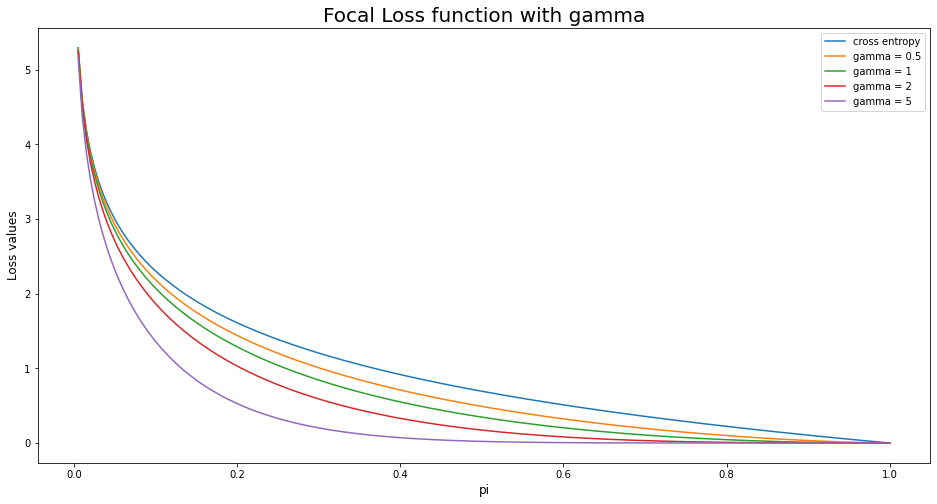

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 1
gammas = [0, 0.5, 1, 2, 5]
p = np.linspace(0, 1, 200)[1:]

def _focal_loss(p, gamma, alpha = 1):
  loss = -(1-p)**gamma*np.log(p)
  return loss

plt.figure(figsize=(16, 8))

for gamma in gammas:
  loss = _focal_loss(p, gamma = gamma)
  if gamma == 0:
    label = 'cross entropy'
  else:
    label = 'gamma = {}'.format(gamma)
  plt.plot(p, loss, label = label)

plt.title('Focal Loss function with gamma', fontsize=20)
plt.xlabel('pi', fontsize=12)
plt.ylabel('Loss values', fontsize=12)
plt.legend()


Ta nhận thấy rằng cross entropy có sự khác biệt giữa giá trị đóng góp vào loss function của các trường hợp xác suất cao (dễ dự báo ) và xác suất thấp (khó dự báo ) là thấp nhất. Khi $\gamma$ càng lớn thì tỷ lệ khác biệt của loss function giữa các trường hợp này càng lớn thể hiện qua đường cong càng trũng xuống.

# 5. Retina net

Ở phần này chúng ta sẽ tìm hiểu về kiến trúc retina net trong lớp bài toán object detection. Nếu bạn đọc chưa biết object detection là gì có thể xem lại các bài [Bài 12: Object detection](https://phamdinhkhanh.github.io/2019/09/29/OverviewObjectDetection.html), [Bài 13: SSD](https://phamdinhkhanh.github.io/2019/10/05/SSDModelObjectDetection.html), [Bài 25: YOLO](https://phamdinhkhanh.github.io/2020/03/09/DarknetAlgorithm.html). Retina net là một mô hình giải quyết được `vấn đề mất cân bằng trong phân phối giữa foreground và background trong các bài toán one-stage detection` bằng cách sử dụng hàm focal loss. Như chúng ta ta đã tìm hiểu ở chương trước, focal loss sẽ giảm thiểu mất mát của những trường hợp dễ dự báo (là foreground) và do đó tập trung hơn vào những trường hợp khó dự báo. Nhờ đó cải thiện được độ chính xác.

Kiến trúc trong bài báo gốc tác giả giới thiệu gồm hai phase:

* Phase 1: là một feature extractor kết hợp giữa Resnet + FPN, có tác dụng trích lọc đặc trưng và trả về các feature map. Mạng FPN (Featuer Pyramid Network) sẽ tạo ra một multi-head  dạng kim tự tháp.

![](https://miro.medium.com/max/690/1*D_EAjMnlR9v4LqHhEYZJLg.png)

**Hình 2:** Kiến trúc FPN. Bao gồm hai nhánh là Bottom-Up bên trái và Top-Down bên phải. 

* Nhánh Bottom-Up là một mạng Convolutional Neural Network (trong bài này là Restnet) giúp tạo ra pyramid level các feature map theo kích thước giảm dần. Những feature map này sẽ được kết hợp với feature map cùng cấp nhánh Top Down. 

* Nhánh Top-Down: Là một mạng upscaling các feature map theo kích thước nhân 2. Như vậy mỗi một level của nhánh bên phải sẽ kết hợp với một level ở nhánh bên trái có cùng kích thước thông qua một phép cộng element-wise additional (cộng các phần tử ở cùng vị trí với nhau). Trước khi thực hiện phép cộng thì level nhánh bên trái được tích chập với feature map `1x1` để giảm thiểu độ sâu channel. Mỗi một phép cộng sẽ trả ra một _merge map_ như các ô predict trong hình.

Như vậy chúng ta thấy kiến trúc của mạng Retina net cũng hoàn toàn đơn giản phải không nào ?

![](https://imgur.com/maph2uj.png)

* Dự báo: Các _merge map_ được sử dụng để dự báo cho các `class+box subnets`. Kiến trúc của một `class+box subnets` gồm hai nhãnh như hình vẽ. 

  * Nhánh phía trên là `class subnet` để dự báo phân phối xác suất của các classes. Bạn để ý rằng số lượng channel ở output của nhánh này là $KA$ chính là số lượng classes x số lượng Anchor. 

  * Nhánh phía dưới là `box subnet` dự báo tọa độ $(c_x, c_y, w, h)$. Do đó đầu ra của chúng có số lượng channel là $4A = 4 \times \text{Number_Anchor}$.

Các dự báo class và box được thực hiện trên từng level với scale khác nhau nhằm phát hiện được vật thể ở đa dạng kích thước.

Kết quả của mô hình RetinaNet

![](https://miro.medium.com/max/1000/1*QQ0RWNKloCGWZ9l6oLu2SA.png)

So sánh với các mô hình One-stage detector lúc bấy giờ thì RetinaNet có kết quả tốt hơn _YOLOv2, SSD513, DSSD513_. Xét trên độ chính xác AP, RetinaNet giúp cải thiện tới 6 điểm (33.2 -> 39.1) so với mô hình tốt kém hơn là _DSSD513_, cả hai cùng sử dụng backbone ResNet101. Đây là kết quả khá tốt.









## 5.1. Xây dựng mô hình

Đã có nhiều code huấn luyện mô hình RetinaNet được chia sẻ. Mình có thể liệt kê một số code tốt :

* Nếu bạn dùng tensorflow: [keras-retinanet](https://github.com/fizyr/keras-retinanet)

* Code trên pytorch: [pytorch-retinanet](https://github.com/yhenon/pytorch-retinanet)

Để khởi tạo được kiến trúc này chúng ta quan tâm tới phần quan trọng nhất đó là kiến trúc ResNet+FPN. Mình sẽ hướng dẫn các bạn phần này trên keras. Source code được trích từ [retinanet](https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py) :



In [ ]:
from tensorflow import keras


class UpsampleLike(keras.layers.Layer):
    """ Một Keras Custom Layer có tác dụng reshape kích thước source tensor về cùng shape với target tensor.
    """

    def call(self, inputs, **kwargs):
        """inputs: list [source, target]
        """
        source, target = inputs
        target_shape = keras.backend.shape(target)
        if keras.backend.image_data_format() == 'channels_first':
            source = backend.transpose(source, (0, 2, 3, 1))
            output = backend.resize_images(source, (target_shape[2], target_shape[3]), method='nearest')
            output = backend.transpose(output, (0, 3, 1, 2))
            return output
        else:
            return backend.resize_images(source, (target_shape[1], target_shape[2]), method='nearest')

    def compute_output_shape(self, input_shape):
        if keras.backend.image_data_format() == 'channels_first':
            return (input_shape[0][0], input_shape[0][1]) + input_shape[1][2:4]
        else:
            return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)


def __create_pyramid_features(backbone_layers, pyramid_levels, feature_size=256):
    """
    Khởi tạo các FPN layers dựa trên các backbone features.
    Args
        backbone_layers: Một dictionary chứa các feature level C3, C4, C5 từ backbone.
        pyramid_levels: Các Pyramid levels được sử dụng.
        feature_size : Độ sâu của các feature level. Mặc định 256.
    Returns
        output_layers : Một từ điển gồm các feature levels.

    """

    output_layers = {}
  
    ## Step 1: upsample C5 để thu được P5 như trong FPN paper 
    P5           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(backbone_layers['C5'])
    P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, backbone_layers['C4']])
    P5           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)
    output_layers["P5"] = P5

    ## Step 2: merge P5_upsampled + C4
    P4           = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(backbone_layers['C4'])
    P4           = keras.layers.Add(name='P4_merged')([P5_upsampled, P4])
    P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, backbone_layers['C3']])
    P4           = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P4')(P4)
    output_layers["P4"] = P4

    ## Step 3: merge P4_upsampled + C3
    P3 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(backbone_layers['C3'])
    P3 = keras.layers.Add(name='P3_merged')([P4_upsampled, P3])
    if 'C2' in backbone_layers and 2 in pyramid_levels:
        P3_upsampled = layers.UpsampleLike(name='P3_upsampled')([P3, backbone_layers['C2']])
    P3 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P3')(P3)
    output_layers["P3"] = P3

    ## Step 4: merge P3_upsampled + C2
    if 'C2' in backbone_layers and 2 in pyramid_levels:
        P2 = keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C2_reduced')(backbone_layers['C2'])
        P2 = keras.layers.Add(name='P2_merged')([P3_upsampled, P2])
        P2 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P2')(P2)
        output_layers["P2"] = P2

    # "P6 thu được thông qua tích chập Conv2D(kernel_size=3, stride=2) trên C5"
    if 6 in pyramid_levels:
        P6 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(backbone_layers['C5'])
        output_layers["P6"] = P6

    # "P7 áp dụng ReLU sau một tích chập Conv2D(kernel_size=3, stride=2) trên P6"
    if 7 in pyramid_levels:
        if 6 not in pyramid_levels:
            raise ValueError("P6 is required to use P7")
        P7 = keras.layers.Activation('relu', name='C6_relu')(P6)
        P7 = keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)
        output_layers["P7"] = P7

    return output_layers

Mỗi một bước trong hàm `__create_pyramid_features()` chúng ta sẽ thực hiện lần lượt các thao tác:

* Tích chập Conv2D với kích thước `1x1` với level $C_i$ bên nhánh Bottom-Up (mạng ResNet) để giảm độ sâu về 256.
* Khởi tạo level $P_{i-1}$ tiếp theo bên nhánh Top-Down (mạng FPN) có kích thước gấp đôi bằng cách upsampling lên gấp đôi kích thước level $P_i$ liền trước. Chính xác hơn, trong code trên thì chúng ta upsample sao cho bằng kích thước của $C_{i-1}$.
* Cộng elementwise additional hai kết quả từ upsampling và tích chập giảm độ sâu.

Chúng ta có thể có option đó là tạo thêm level thấp nhất bắt đầu từ $P_2$ và tạo thêm level cao nhất bắt đầu từ $P_7$ tùy vào khai báo trong pyramid_levels.

Chi tiết về quá trình huấn luyện các bạn có thể xem tại [REAME-keras-retinanet](https://github.com/fizyr/keras-retinanet).

# 6. Kết luận

Như vậy qua bài này các bạn đã được nắm bắt thêm một thuật toán mới được áp dụng trong object detection đó là RetinaNet. Điểm khác biệt tạo ra thành công của RetinaNet đó là áp dụng mạng FPN, một multi-scale levels map và áp dụng Focal Loss để tăng cường độ chính xác khi dự báo vị trí chứa object. Mình tin rằng đây là ý tưởng độc đáo và nó sẽ còn tiếp tục được kế thừa trong những lớp mô hình SOTA về sau. Cuối cùng không thể thiếu là những tài liệu tham khảo mà mình đã sử dụng để viết bài viết này.


# 7. Tài liệu

1. [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf)
2. [Review retinanet focal loss object detection - Sik-Ho Tsang](https://towardsdatascience.com/review-retinanet-focal-loss-object-detection-38fba6afabe4)
3. [Review: FPN — Feature Pyramid Network (Object Detection) - Sik-Ho Tsang](https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610)
4. [How retinanet works](https://developers.arcgis.com/python/guide/how-retinanet-works/)
5. [Focal Loss Explained - LeiMao](https://leimao.github.io/blog/Focal-Loss-Explained/)
6. [Focal Loss for Dense Object Detection](https://deep-learning-study-note.readthedocs.io/en/latest/Part%202%20(Modern%20Practical%20Deep%20Networks)/12%20Applications/Computer%20Vision%20External/Focal%20Loss%20for%20Dense%20Object%20Detection.html)
7. [The intuition behind retinanet - Prakash Jay
](https://medium.com/@14prakash/the-intuition-behind-retinanet-eb636755607d)
8. [Object Detection with retinanet - Keras Tutorial](https://keras.io/examples/vision/retinanet/)